# Import libraries and Load Data

In [498]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

plt.style.use("ggplot")
df = pd.read_csv("top_5_leagues_match_data.csv")

In [499]:
df.head()

,match_date,day,match_hour,week,country,season,league,venue,team,gf,ga,opponent,result,goal_diff
0,2024-08-17,Saturday,14,1,England,2024/2025,Premier League,Home,Arsenal,2,0,Wolverhampton,W,2
1,2024-08-24,Saturday,16,2,England,2024/2025,Premier League,Away,Arsenal,2,0,Aston Villa,W,2
2,2024-08-31,Saturday,11,3,England,2024/2025,Premier League,Home,Arsenal,1,1,Brighton Hove,D,0
3,2024-09-15,Sunday,13,4,England,2024/2025,Premier League,Away,Arsenal,1,0,Tottenham,W,1
4,2024-09-22,Sunday,15,5,England,2024/2025,Premier League,Away,Arsenal,2,2,Man City,D,0


# Exploratory Data Analysis

##### Understanding the data

In [500]:
print("Info:")
df.info()

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6098 entries, 0 to 6097
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   match_date  6098 non-null   object
 1   day         6098 non-null   object
 2   match_hour  6098 non-null   int64 
 3   week        6098 non-null   int64 
 4   country     6098 non-null   object
 5   season      6098 non-null   object
 6   league      6098 non-null   object
 7   venue       6098 non-null   object
 8   team        6098 non-null   object
 9   gf          6098 non-null   int64 
 10  ga          6098 non-null   int64 
 11  opponent    6098 non-null   object
 12  result      6098 non-null   object
 13  goal_diff   6098 non-null   int64 
dtypes: int64(5), object(9)
memory usage: 667.1+ KB


In [501]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
match_hour,6098.0,16.016891,2.497342,10.0,14.0,16.0,18.0,20.0
week,6098.0,18.808626,10.624348,1.0,10.0,19.0,28.0,38.0
gf,6098.0,1.494424,1.266538,0.0,1.0,1.0,2.0,8.0
ga,6098.0,1.370121,1.210340,0.0,0.0,1.0,2.0,8.0
goal_diff,6098.0,0.124303,1.827647,-8.0,-1.0,0.0,1.0,8.0


In [502]:
df["match_date"] = pd.to_datetime(df["match_date"])

In [503]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols

(['match_hour', 'week', 'gf', 'ga', 'goal_diff'],
 ['day', 'country', 'season', 'league', 'venue', 'team', 'opponent', 'result'])

In [504]:
df.team.value_counts()

team
Arsenal       76
Osasuna       76
Inter         76
Juventus      76
Lazio         76
              ..
St. Pauli     34
Angers SCO    34
FC Metz       34
1. FC Köln    34
Lorient       34
Name: count, Length: 91, dtype: int64

In [505]:
print("Number of unique teams:", df["team"].nunique())
print("Number of unique opponents:", df["opponent"].nunique())
opp_lists = df["opponent"].unique().tolist()
team_lists = df["team"].unique().tolist()
diff_lists = list(set(opp_lists) - set(team_lists))
print("These are the teams that were relegated at one point or the api does not provide data for, that is why we don't see them in the current teams:")
print(diff_lists)

Number of unique teams: 91
Number of unique opponents: 110
These are the teams that were relegated at one point or the api does not provide data for, that is why we don't see them in the current teams:
['Darmstadt', 'Leganés', 'Almería', 'Luton Town', 'Cádiz CF', 'Valladolid', 'Stade de Reims', 'Holstein Kiel', 'Las Palmas', 'Montpellier', 'Salernitana', 'Frosinone', 'Venezia FC', 'Empoli', 'Granada', 'Clermont Foot', 'Saint-Étienne', 'Monza', 'Bochum']


## Visualizations

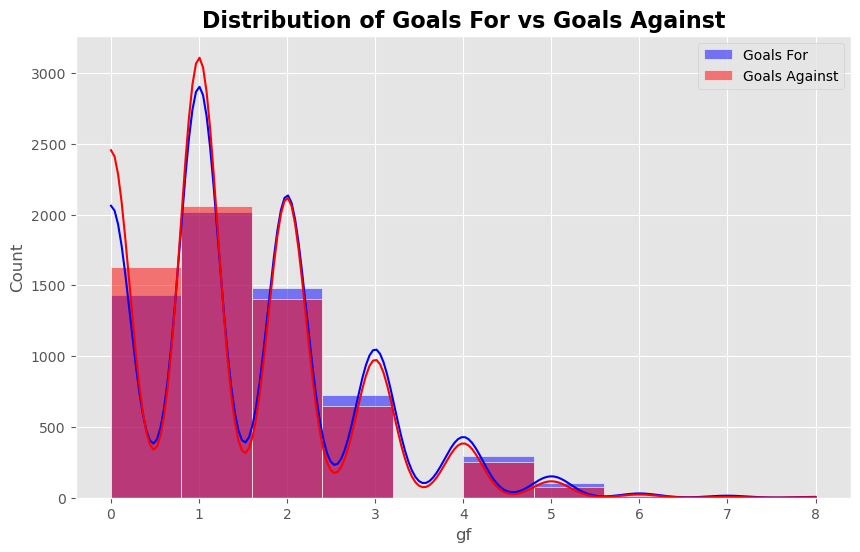

In [506]:
# Distribution of Goals For vs Goals Against
plt.figure(figsize=(10,6))
sns.histplot(df["gf"], kde=True, bins=10, color="blue", label="Goals For")
sns.histplot(df["ga"], kde=True, bins=10, color="red", label="Goals Against")
plt.title("Distribution of Goals For vs Goals Against", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

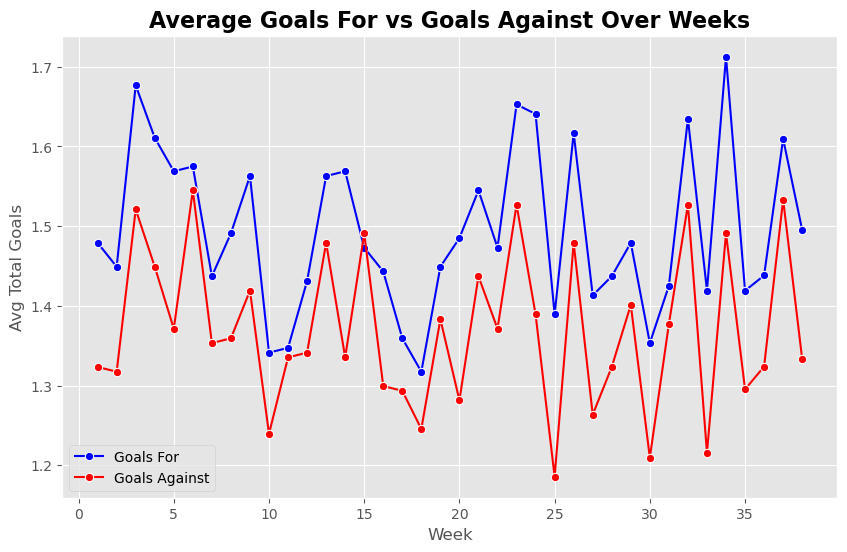

In [507]:
# Weekly average goals
weekly = df.groupby("week")[["gf", "ga"]].mean()

# Average goals scored and conceded over the weeks
plt.figure(figsize=(10,6))
sns.lineplot(x=weekly.index, y=weekly["gf"], marker="o", color="blue", label="Goals For")
sns.lineplot(x=weekly.index, y=weekly["ga"], marker="o", color="red", label="Goals Against")
plt.title("Average Goals For vs Goals Against Over Weeks", fontsize=16, fontweight="bold")
plt.xlabel("Week")
plt.ylabel("Avg Total Goals")
plt.legend()
plt.show()

/var/folders/zw/0r7lrnz93fl6vjghx4b87mf80000gn/T/ipykernel_9775/1249115559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="gf", y="team", data=top_teams, palette="Blues_r", edgecolor="black")


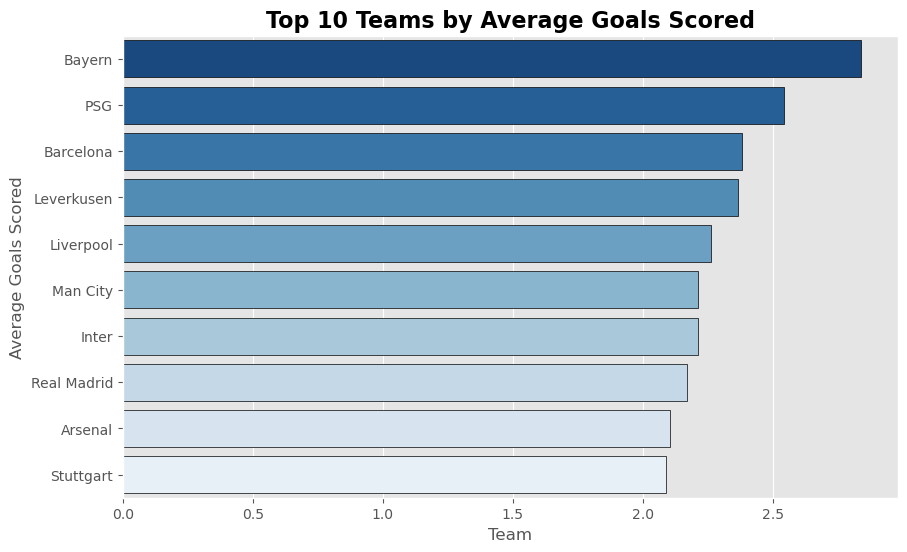

In [508]:
# Top 10 teams in Europe by average goals scored
top_teams = df.groupby("team")["gf"].mean().reset_index().sort_values("gf", ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x="gf", y="team", data=top_teams, palette="Blues_r", edgecolor="black")
plt.title("Top 10 Teams by Average Goals Scored", fontsize=16, fontweight="bold")
plt.ylabel("Average Goals Scored")
plt.xlabel("Team")
plt.show()

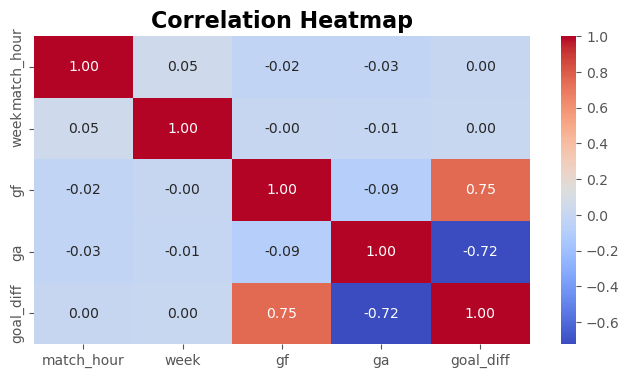

In [509]:
# Correlation heatmap
correlations = df[num_cols].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=16, fontweight="bold")
plt.show()

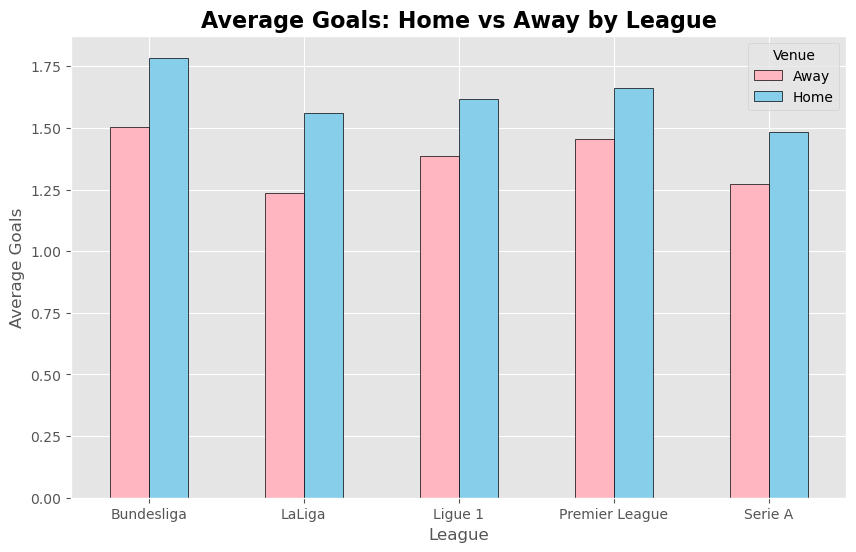

In [510]:
gf_avg = df.pivot_table(index="league", columns="venue", values="gf", aggfunc="mean")

# Home advantage shown by average goals by league
gf_avg.plot(kind="bar", figsize=(10,6), color=["lightpink", "skyblue"], edgecolor="black")
plt.title("Average Goals: Home vs Away by League", fontsize=16, fontweight="bold")
plt.ylabel("Average Goals")
plt.xlabel("League")
plt.xticks(rotation=0)
plt.legend(title="Venue")
plt.show()

In [511]:
# Count results by league and venue
result_counts = df.groupby(["league","venue"])["result"].value_counts().unstack(fill_value=0)

# Calculate percentage
result_counts_percentage = result_counts.div(result_counts.sum(axis=1), axis=0) * 100

result_counts_percentage


result                        D          L          W
league         venue                                 
Bundesliga     Away   25.919118  38.602941  35.477941
               Home   25.919118  30.147059  43.933824
LaLiga         Away   27.910686  39.234450  32.854864
               Home   25.837321  25.358852  48.803828
Ligue 1        Away   23.921569  39.803922  36.274510
               Home   22.549020  31.176471  46.274510
Premier League Away   23.076923  42.780027  34.143050
               Home   23.076923  32.928475  43.994602
Serie A        Away   28.389155  37.639553  33.971292
               Home   29.186603  25.677831  45.135566

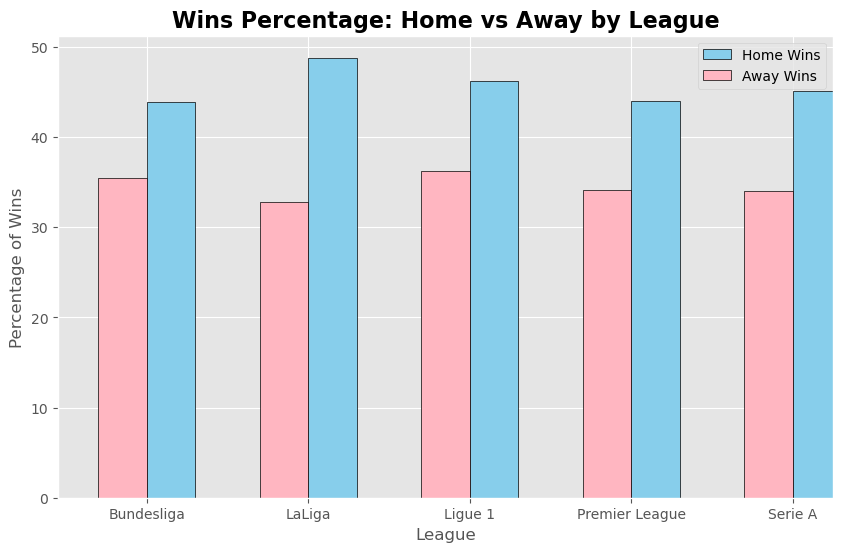

In [512]:
# Separate Home vs Away
home = result_counts_percentage.xs("Home", level="venue")
away = result_counts_percentage.xs("Away", level="venue")

plt.figure(figsize=(10, 6))

# Bar plot for Home Win percentages by league
home["W"].plot(kind="bar", color="skyblue", width=0.3, edgecolor="black", position=0, label="Home Wins")
away["W"].plot(kind="bar", color="lightpink", width=0.3, edgecolor="black", position=1, label="Away Wins")

plt.title("Wins Percentage: Home vs Away by League", fontsize=16, fontweight="bold")
plt.ylabel("Percentage of Wins")
plt.xlabel("League")
plt.xticks(rotation=0)
plt.legend()
plt.show()

## Feature Engineering

In [513]:
label_encoder = LabelEncoder()

# Encode categorical features
df["opponent_id"] = label_encoder.fit_transform(df["opponent"])
df["team_id"] = label_encoder.fit_transform(df["team"])
df["venue_id"] = label_encoder.fit_transform(df["venue"])
df["day_id"] = label_encoder.fit_transform(df["day"])

# Encode target variable
df["target"] = df["result"].apply(lambda x: 1 if x == "W" else 0)

df.head()

,match_date,day,match_hour,week,country,season,league,venue,team,gf,ga,opponent,result,goal_diff,opponent_id,team_id,venue_id,day_id,target
0,2024-08-17,Saturday,14,1,England,2024/2025,Premier League,Home,Arsenal,2,0,Wolverhampton,W,2,109,3,1,2,1
1,2024-08-24,Saturday,16,2,England,2024/2025,Premier League,Away,Arsenal,2,0,Aston Villa,W,2,5,3,0,2,1
2,2024-08-31,Saturday,11,3,England,2024/2025,Premier League,Home,Arsenal,1,1,Brighton Hove,D,0,19,3,1,2,0
3,2024-09-15,Sunday,13,4,England,2024/2025,Premier League,Away,Arsenal,1,0,Tottenham,W,1,98,3,0,3,1
4,2024-09-22,Sunday,15,5,England,2024/2025,Premier League,Away,Arsenal,2,2,Man City,D,0,63,3,0,3,0


In [514]:
df["target"].value_counts() # Imbalanced

target
0    3658
1    2440
Name: count, dtype: int64

In [515]:
predictor_cols = [
    "match_hour",
    "week",
    "team_id",
    "opponent_id",
    "venue_id",
    "day_id"
]

# Training Model and Evaluation

In [516]:
# Function to evaluate model performance
def evaluate_model(y_test, y_pred, model_name, league_name):
    # Calculate Scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    
    # Left: Metrics
    ax1.axis('off')
    metrics_text = f"""
    LEAGUE: {league_name}
    MODEL: {model_name}
    
    Accuracy:  {accuracy:.2%}
    Precision: {precision:.2%}
    Recall:    {recall:.2%}
    F1 Score:  {f1:.2%}
    """
    ax1.text(0.1, 0.9, metrics_text, fontsize=14, fontfamily='monospace', 
             verticalalignment='top', linespacing=1.5)
    ax1.set_title('Performance Metrics', fontsize=16, pad=20)

    
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap 
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma")
    
    plt.title("Confusion Matrix", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [517]:
# Dictionaries later used for comparison
scores_before_rolling_averages = {}
scores_after_rolling_averages = {}


# Function to train and predict match outcomes
def predict_matches(df, name, predictors = predictor_cols):
    # Split the data into train and test sets by date
    train = df[df["match_date"] < "2025-02-07"]
    test = df[df["match_date"] >= "2025-02-07"]

    X_train = train[predictors]
    X_test = test[predictors]
    y_train = train["target"]
    y_test = test["target"]


    # Models Dictionary
    models = {
            "RandomForest": RandomForestClassifier(random_state=42),
            "XGBoost": XGBClassifier(random_state=42),
            "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
            "AdaBoost": AdaBoostClassifier(random_state=42)
        }
    
    # Train and evaluate models
    for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print(f"Evaluation results for {model_name} on {name}:")
            evaluate_model(y_test, y_pred, model_name, name)

            # Store scores before adding new columns
            if predictors == predictor_cols:
                scores_before_rolling_averages[f"{model_name}_{name}"] = {
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "Precision": precision_score(y_test, y_pred, average='weighted'),
                    "Recall": recall_score(y_test, y_pred, average='weighted'),
                    "F1": f1_score(y_test, y_pred, average='weighted')
        }
            # Store scores after adding new columns
            else:
                scores_after_rolling_averages[f"{model_name}_{name}"] = {
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "Precision": precision_score(y_test, y_pred, average='weighted'),
                    "Recall": recall_score(y_test, y_pred, average='weighted'),
                    "F1": f1_score(y_test, y_pred, average='weighted')
        }

In [518]:
# Function to compare model scores before and after adding new features
def compare_scores():
    for key in scores_before_rolling_averages.keys():
        before = scores_before_rolling_averages[key]
        after = scores_after_rolling_averages.get(key)
        if after is not None:
            print(f"Comparison for {key}:")
            print(f" - Before: {before}")
            print(f" - After: {after}")
            print()

In [519]:
# DataFrames for each league
df_eng = df[df["league"] == "Premier League"].copy()
df_ger = df[df["league"] == "Bundesliga"].copy()
df_ita = df[df["league"] == "Serie A"].copy()
df_fra = df[df["league"] == "Ligue 1"].copy()
df_esp = df[df["league"] == "LaLiga"].copy()

Processing league: Premier League
Evaluation results for RandomForest on Premier League:


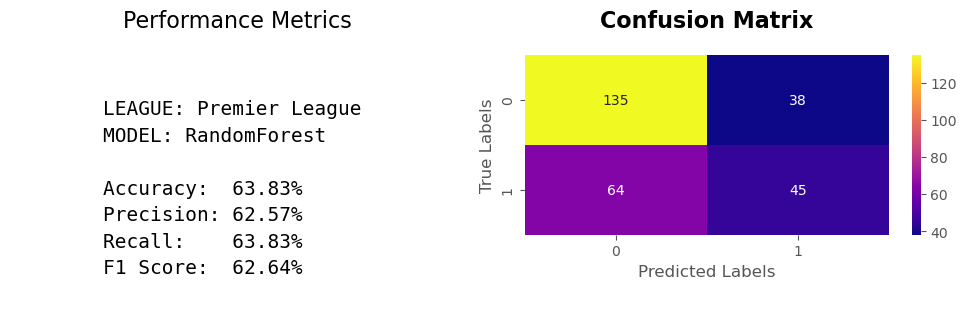

Evaluation results for XGBoost on Premier League:


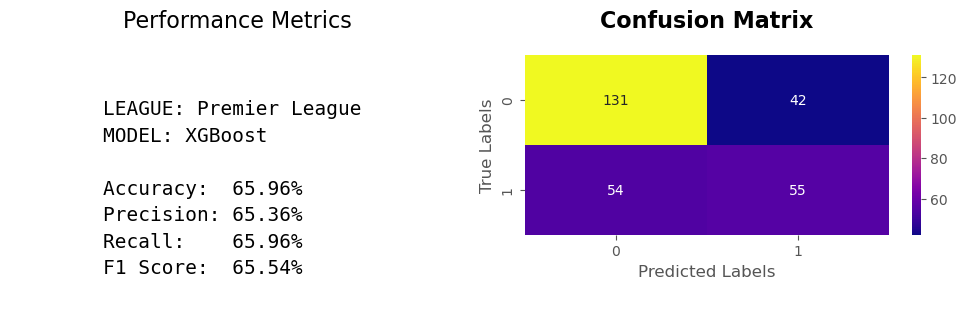

Evaluation results for LightGBM on Premier League:


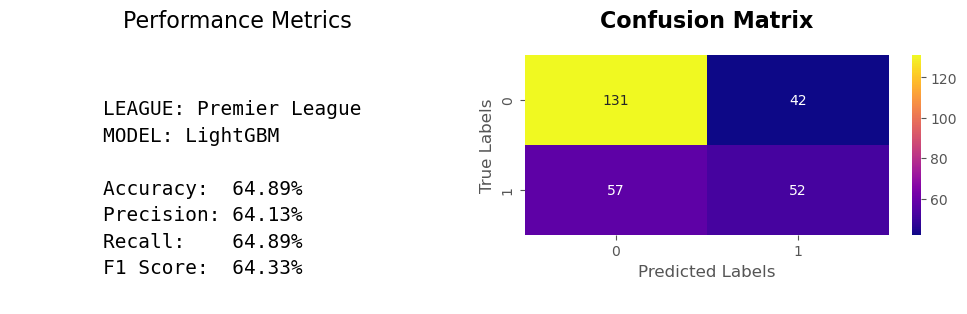

Evaluation results for AdaBoost on Premier League:


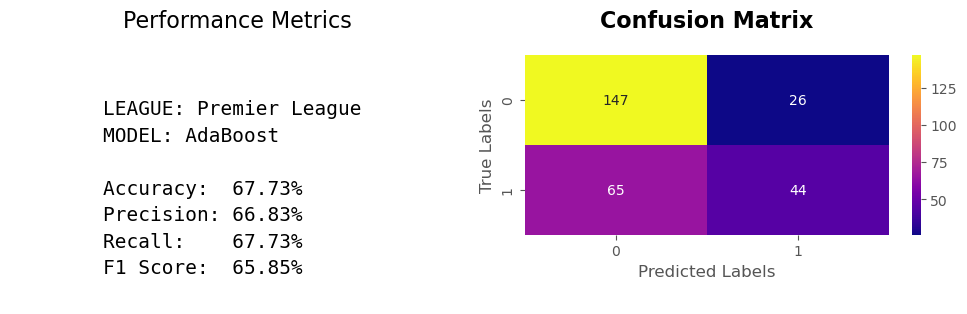

Processing league: Serie A
Evaluation results for RandomForest on Serie A:


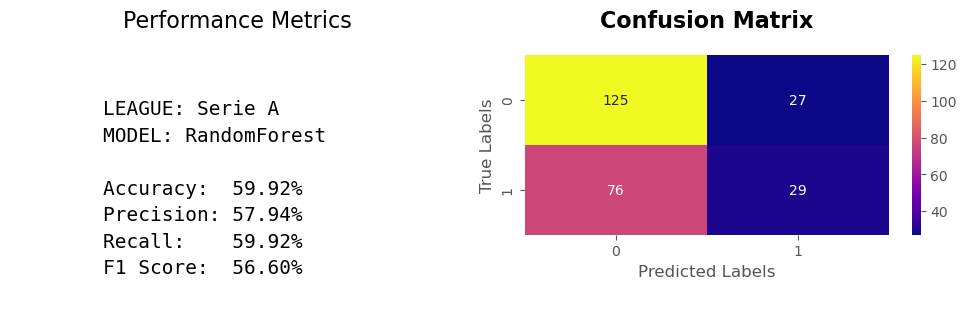

Evaluation results for XGBoost on Serie A:


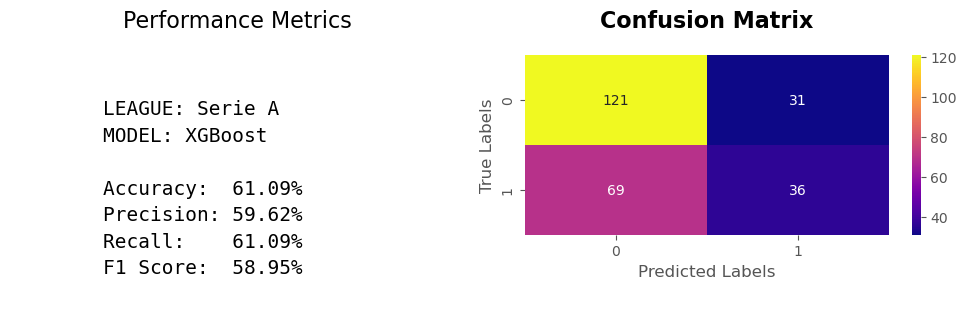

Evaluation results for LightGBM on Serie A:


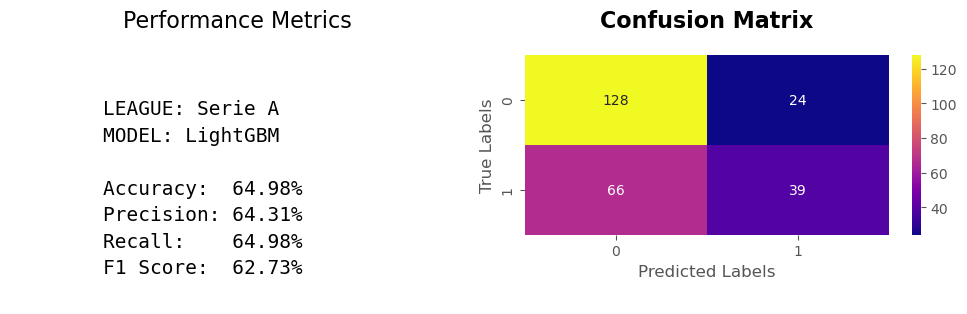

Evaluation results for AdaBoost on Serie A:


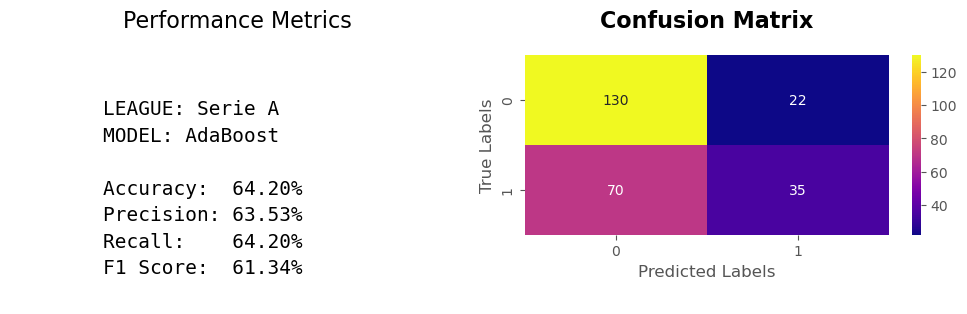

Processing league: LaLiga
Evaluation results for RandomForest on LaLiga:


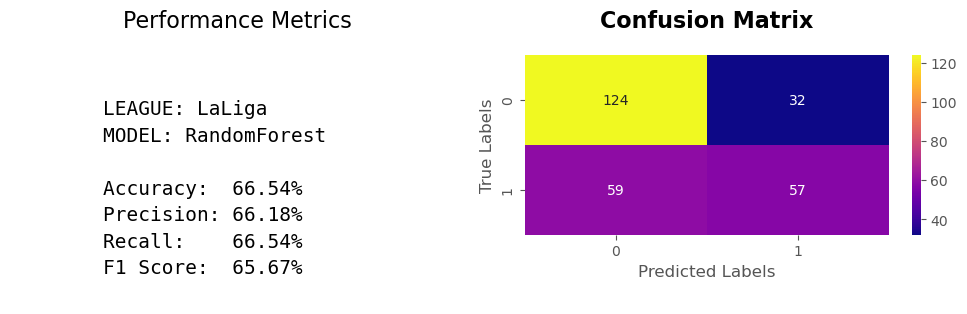

Evaluation results for XGBoost on LaLiga:


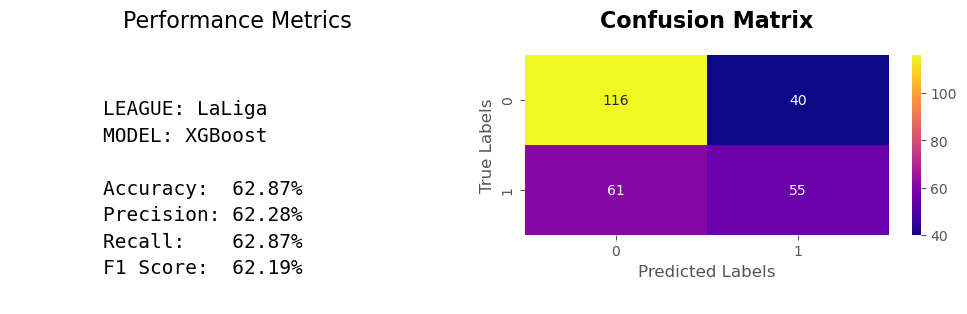

Evaluation results for LightGBM on LaLiga:


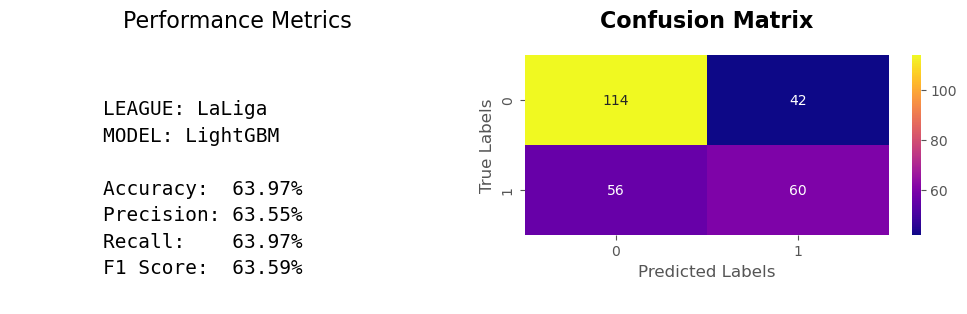

Evaluation results for AdaBoost on LaLiga:


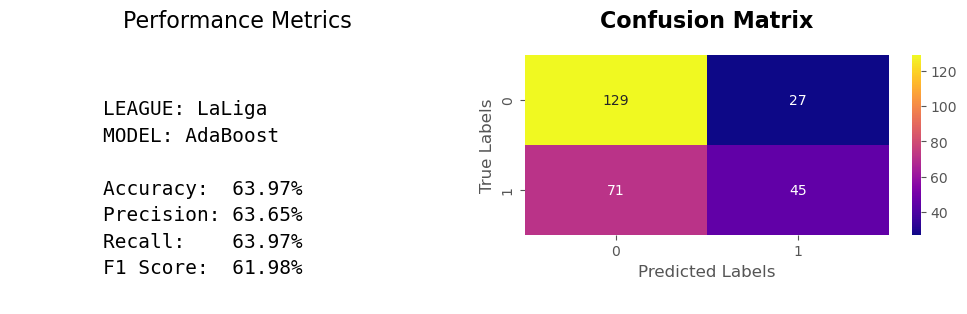

Processing league: Ligue 1
Evaluation results for RandomForest on Ligue 1:


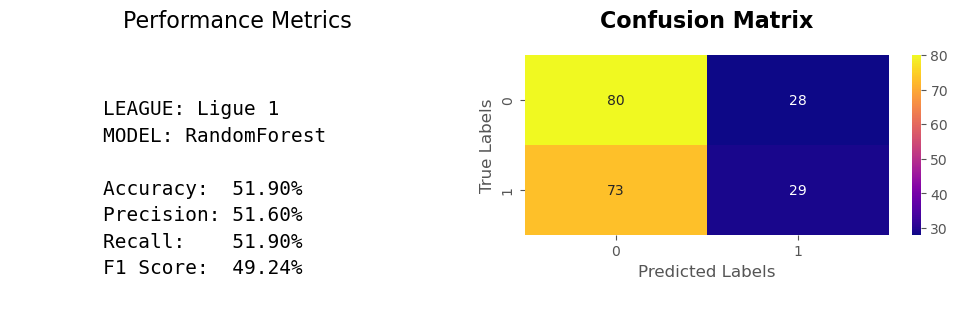

Evaluation results for XGBoost on Ligue 1:


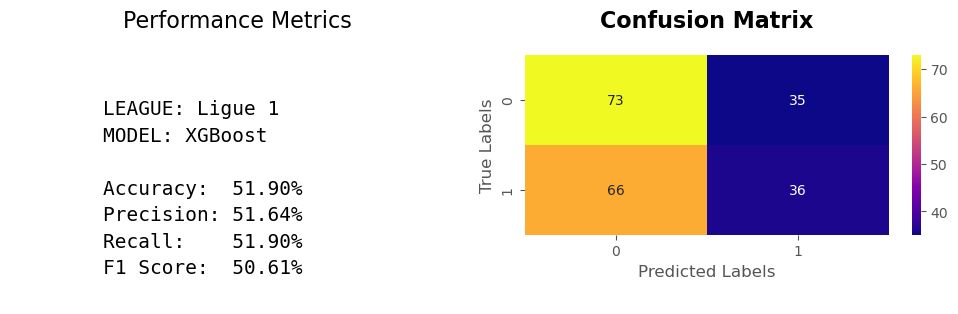

Evaluation results for LightGBM on Ligue 1:


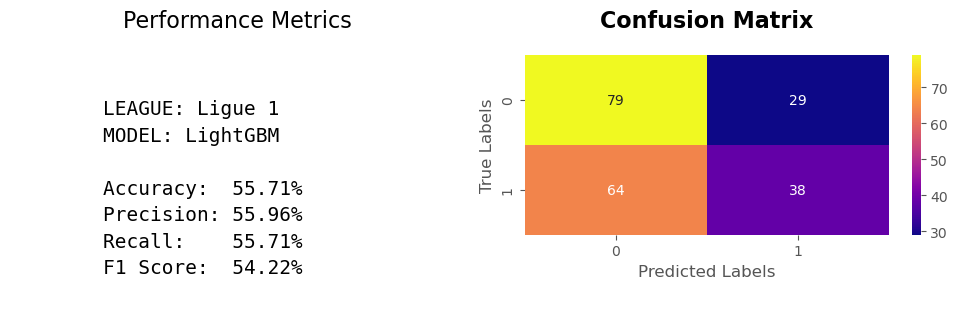

Evaluation results for AdaBoost on Ligue 1:


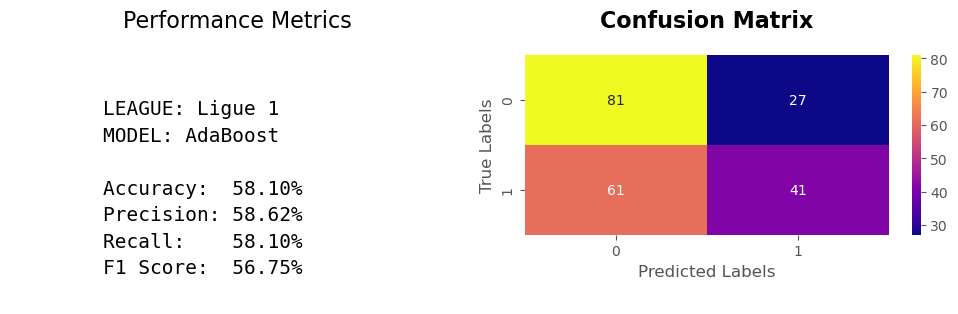

Processing league: Bundesliga
Evaluation results for RandomForest on Bundesliga:


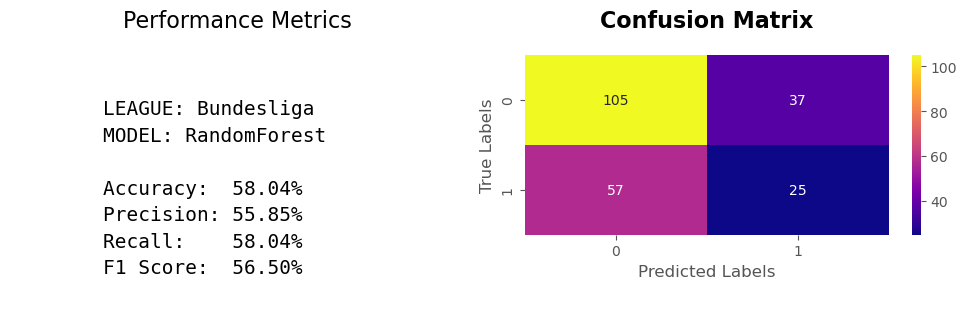

Evaluation results for XGBoost on Bundesliga:


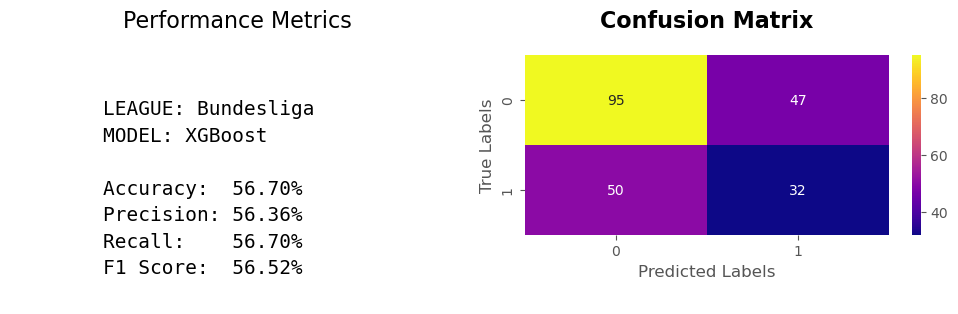

Evaluation results for LightGBM on Bundesliga:


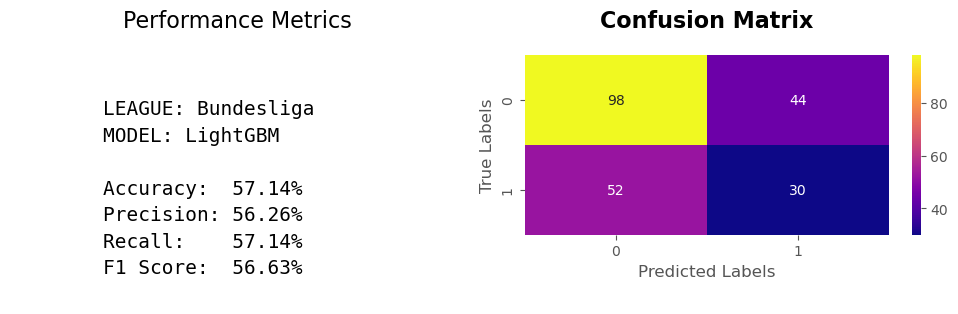

Evaluation results for AdaBoost on Bundesliga:


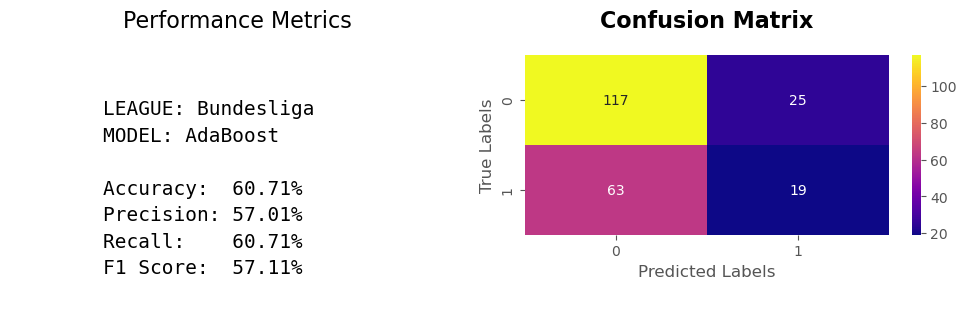

In [520]:
leagues = [df_eng, df_ita, df_esp, df_fra, df_ger]

# Process each league
for df in leagues:
    name = df["league"].iloc[0]
    print(f"Processing league: {name}")
    predict_matches(df, name, predictor_cols)

## Improving Models

### As you can see Bundesliga and Ligue 1 has worse scores compared to other leagues. We will now add rolling averages columns to include the teams last matches' performance. These will also be used for our predictions to improve our scores.

In [521]:
# Function to calculate rolling averages (how the team performed over the last matches)
def rolling_averages(team, cols, new_cols):
    team = team.sort_values("match_date")
    performance = team[cols].rolling(8, closed="left").mean()
    team[new_cols] = performance
    team = team.dropna(subset=new_cols)
    return team

# New columns are added to the predictor columns
cols = ["gf", "ga", "goal_diff"]
new_cols = [f"rolling_{col}" for col in cols]
new_cols 

['rolling_gf', 'rolling_ga', 'rolling_goal_diff']

Processing league: Bundesliga
Evaluation results for RandomForest on Bundesliga:


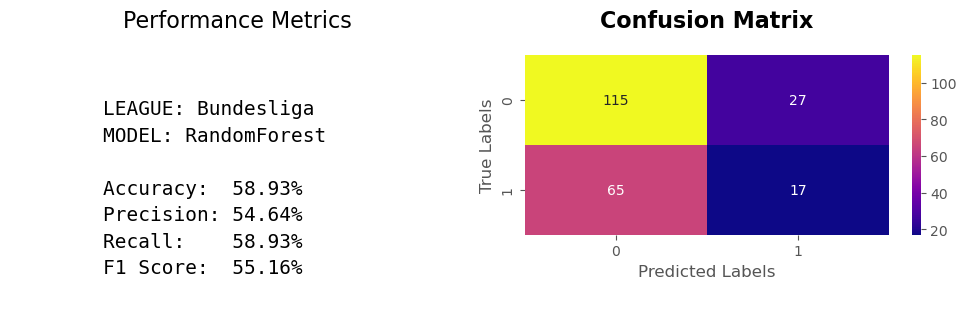

Evaluation results for XGBoost on Bundesliga:


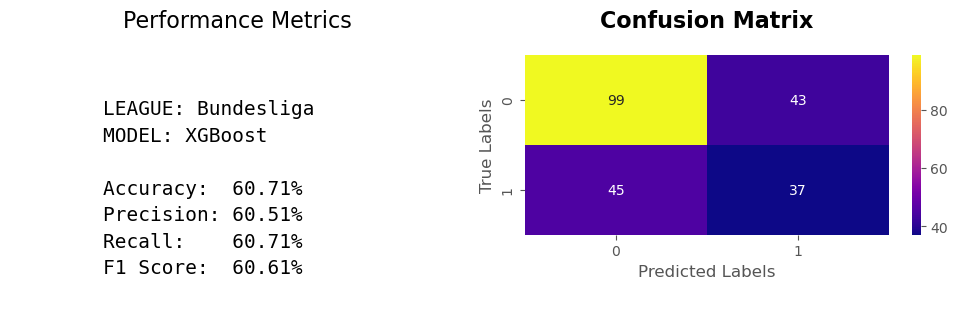

Evaluation results for LightGBM on Bundesliga:


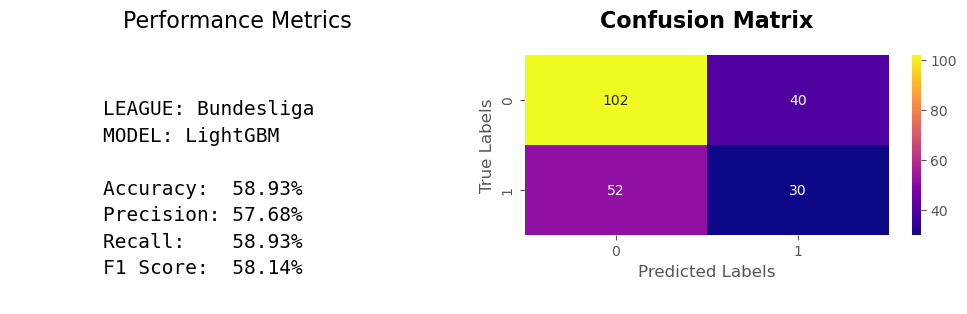

Evaluation results for AdaBoost on Bundesliga:


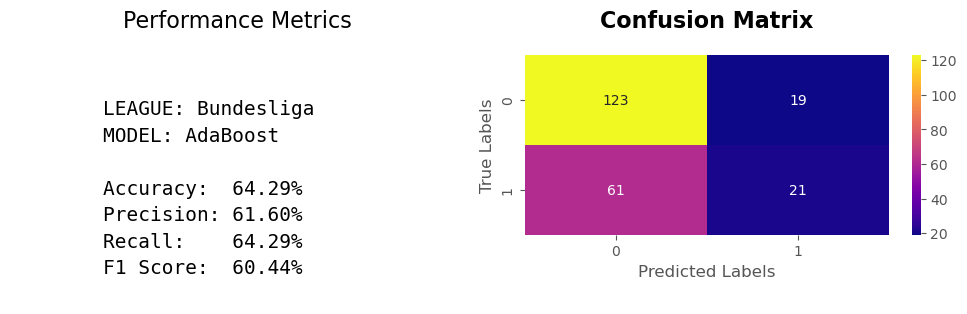

Processing league: Ligue 1
Evaluation results for RandomForest on Ligue 1:


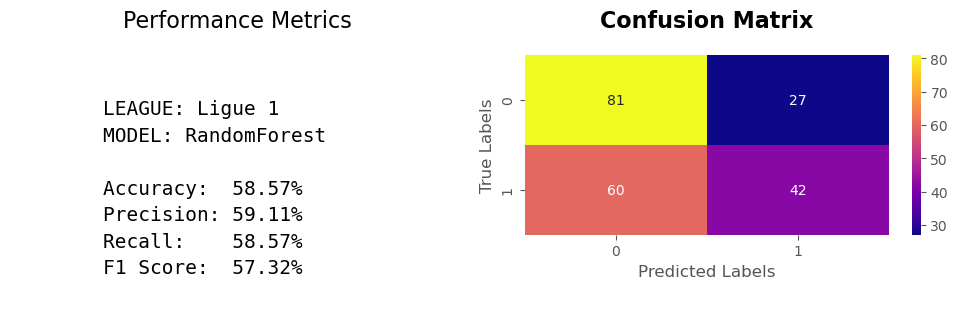

Evaluation results for XGBoost on Ligue 1:


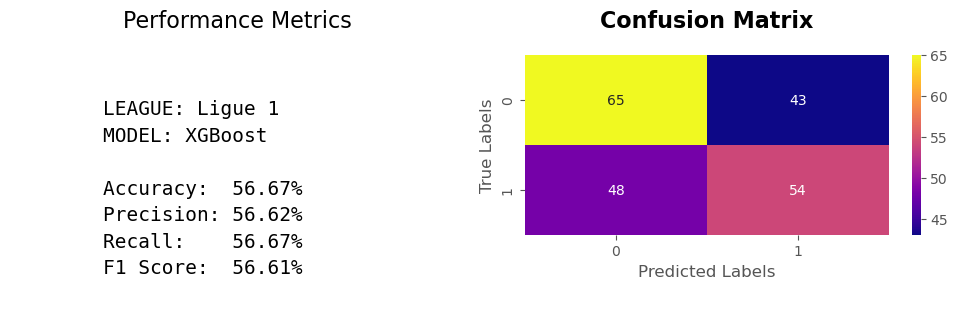

Evaluation results for LightGBM on Ligue 1:


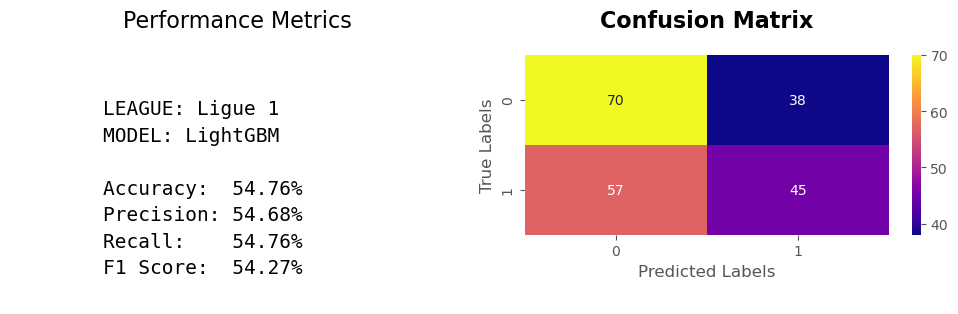

Evaluation results for AdaBoost on Ligue 1:


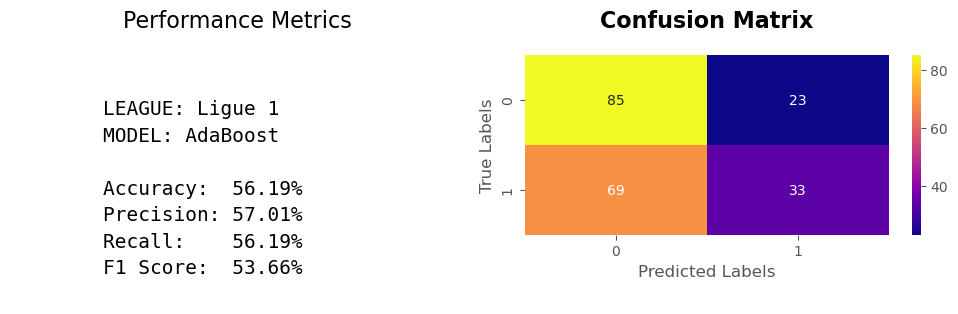

In [522]:
leagues_with_low_accuracy = [df_ger, df_fra]

# Process low accuracy leagues with rolling averages to improve performance
for df in leagues_with_low_accuracy:
    name = df["league"].iloc[0]
    print(f"Processing league: {name}")
    df_perf = df.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols), include_groups=False).reset_index(drop=True)
    predict_matches(df_perf, name, predictor_cols + new_cols)


### Ligue 1 and Bundesliga scores increased.

In [523]:
compare_scores()

Comparison for RandomForest_Ligue 1:
 - Before: {'Accuracy': 0.5190476190476191, 'Precision': 0.5160253575114256, 'Recall': 0.5190476190476191, 'F1': 0.4924497320073117}
 - After: {'Accuracy': 0.5857142857142857, 'Precision': 0.5910929033963261, 'Recall': 0.5857142857142857, 'F1': 0.5731920161850408}

Comparison for XGBoost_Ligue 1:
 - Before: {'Accuracy': 0.5190476190476191, 'Precision': 0.5163701634266028, 'Recall': 0.5190476190476191, 'F1': 0.5061377320580241}
 - After: {'Accuracy': 0.5666666666666667, 'Precision': 0.5662257093330901, 'Recall': 0.5666666666666667, 'F1': 0.5661247413538281}

Comparison for LightGBM_Ligue 1:
 - Before: {'Accuracy': 0.5571428571428572, 'Precision': 0.5595956282523447, 'Recall': 0.5571428571428572, 'F1': 0.5421613630010811}
 - After: {'Accuracy': 0.5476190476190477, 'Precision': 0.54680363749712, 'Recall': 0.5476190476190477, 'F1': 0.5426764150168405}

Comparison for AdaBoost_Ligue 1:
 - Before: {'Accuracy': 0.580952380952381, 'Precision': 0.58621730382

# Best models for each league and their accuracy scores:

### Premier League : AdaBoost  |  67.73%
### LaLiga : RandomForest  |  66.54%
### Serie A : LightGBM  |  64.98%
### BUNDESLIGA : AdaBoost  |  64.29%
### LIGUE 1 : RandomForest  |  58.57%